In [1]:
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg

In [2]:
import matplotlib.pyplot as plt

In [3]:
import cProfile
import pstats

--------

### Set the number of resources

In [4]:
L = 10

### Define the ancestral phenotype (traits vector)

In [5]:
anc_phenotype = utils.random_matrix(shape=(10, L), mode='binomial')

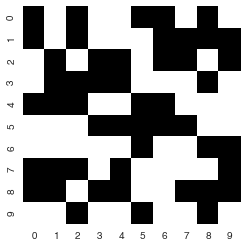

In [6]:
viz.matrix_plot(anc_phenotype)

### Define the system biochemistry (trait/resource interactions)

In [7]:
J = utils.random_matrix((L, L), 'tikhonov_sigmoid')

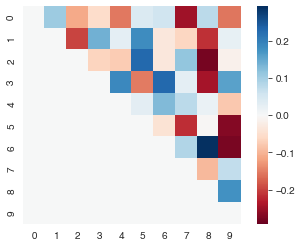

In [8]:
viz.matrix_plot(J)

### Parameterize and instantiate the Consumer-Resource System

In [9]:
anc_system = ConsumerResourceSystem(sigma=anc_phenotype, 
                                    b=1, k=1e10, c=0.1, chi=0.5, J=J, mu=1e-10,
                                    resource_consumption_mode='fast_resource_eq',
                                    threshold_min_rel_abundance=1e-6,
                                    N_init=1, R_init=1)

### Simulate dynamics

In [10]:
# anc_system.run(T=1000)

In [11]:
profile = cProfile.Profile()
profile.runcall(anc_system.run)

In [12]:
# ps = pstats.Stats(profile)
# ps.sort_stats('tottime')
# ps.print_stats()

### Visualize results

In [13]:
type_colors = viz.color_types_by_phylogeny(anc_system.type_set, apply_palette_depth=0)

<AxesSubplot:>

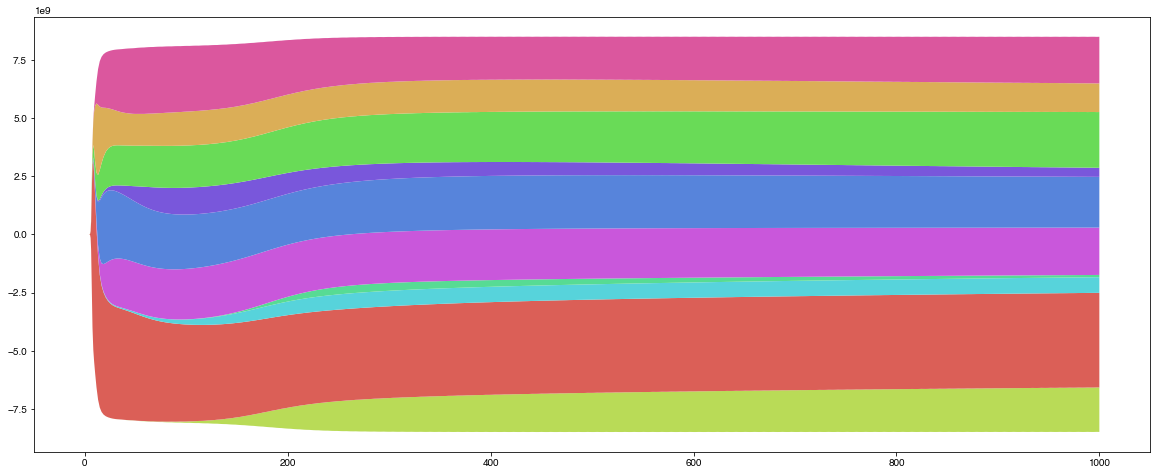

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(anc_system, ax=ax, type_colors=type_colors)

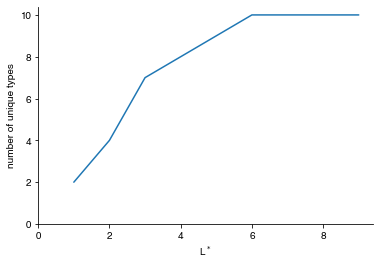

In [15]:
viz.Lstar_types_plot(anc_system)

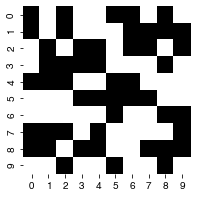

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_system.get_extant_type_set().sigma, ax=ax)